In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
words = open('names.txt', 'r').read().splitlines()


In [7]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [8]:
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context) 
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [9]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [10]:
# MLP revisited
n_embed = 10 # embedding dimension
n_hidden = 200 # hidden layer size
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((len(stoi), n_embed), generator=g)
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g) * ((5/3) / ((n_embed*block_size)**0.5))   # * 0.2
#  = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, len(stoi)), generator=g) * 0.01
b2 = torch.randn(len(stoi), generator=g) * 0.0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [13]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb] # batch_size, context_size, embedding_size
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 # + b1 # batch_size, n_hidden
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    # Update running mean and std
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


    h = torch.tanh(hpreact) # batch_size, n_hidden
    logits = h @ W2 + b2 # batch_size, num_classes
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()


    # Update
    lr = 0.1 if i < 100000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())



      0/ 200000: 3.2879
  10000/ 200000: 2.3239
  20000/ 200000: 2.0221
  30000/ 200000: 2.0298
  40000/ 200000: 2.0629
  50000/ 200000: 2.8945
  60000/ 200000: 2.1050
  70000/ 200000: 2.8188
  80000/ 200000: 2.5734
  90000/ 200000: 2.2486
 100000/ 200000: 2.0447
 110000/ 200000: 1.8231
 120000/ 200000: 1.8341
 130000/ 200000: 2.4104
 140000/ 200000: 2.4917
 150000/ 200000: 2.4235
 160000/ 200000: 2.1188
 170000/ 200000: 2.1723
 180000/ 200000: 2.1491
 190000/ 200000: 2.1050


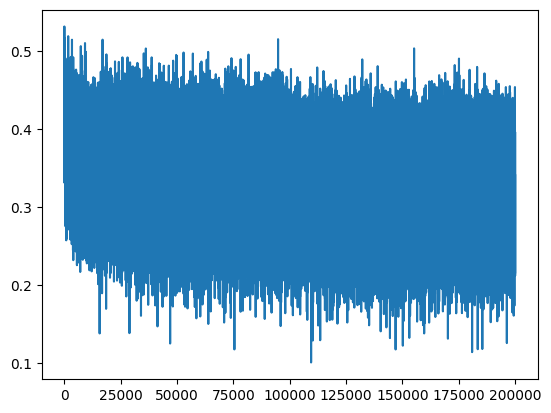

In [14]:
plt.plot(lossi)

In [17]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # batch_size, context_size, embedding_size
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1 # batch_size, n_hidden
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # batch_size, n_hidden
    logits = h @ W2 + b2 # batch_size, num_classes
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item():.4f}")
split_loss('train')
split_loss('val')

train loss: 2.0672
val loss: 2.1057


In [18]:
# sample from the model
context_size = 3
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * context_size
    while True:
        emb = C[torch.tensor([context])] # 1, context_size, embedding_size
        embcat = emb.view(1, -1) 
        h = torch.tanh(embcat @ W1) # 1, n_hidden
        logits = h @ W2 + b2 # 1, num_classes
        probs = F.softmax(logits, dim=1) # 1, num_classes
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(itos[ix])
    print(''.join(out)) 

cathlifatubhl
shkirrsthlithl
kaydanshantubngelssahmiquelissellaritziahirdg
leggyufbmghziriqustzishlistan
vabiusstell
diarisix
khegzifsabbel
zaiirsgtleynanfidah
qseidh
sussaddmaboubzettlej
sandassadnykelsadlulbseomssissiaghubniq
qlllsantwa
sumishdyb
subbidaniffertiaggbecklrudgkyasislytte
conzabbuljadak
khlesdanikosmuseff
kyaq
blustre
boktnyah
jzithly


In [ ]:
torch.tensor(1/27.0).log()

In [ ]:
# 4-dimensional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

In [ ]:
# Summary ------

In [ ]:
# Let's train a deeper network

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters trained with backprop
        self.gamma = torch.ones((1, dim))
        self.beta = torch.zeros((1, dim))
        # buffers (trained with a running `momentum update')
        self.running_mean = torch.zeros((1, dim))
        self.running_var = torch.ones((1, dim))

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                # Update running stats
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []